## Setting Kaggle API and Download Dataset

In [ ]:
from IPython.display import clear_output
!pip install kaggle==1.5.12

clear_output()

In [ ]:
# Upload Kaggle API
from  google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"richalfajril","key":"a0507aa9a68a4bf536e6cdc8a86b293b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download Dataset

!kaggle datasets download -d agustrinaldo/nlp-emotion-text-dataset-bahasa-indonesia/data

  0% 0.00/651k [00:00<?, ?B/s]
100% 651k/651k [00:00<00:00, 75.3MB/s]


In [ ]:
#Unzip Dataset

!unzip nlp-emotion-text-dataset-bahasa-indonesia.zip
clear_output()

## Imports

In [ ]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import sklearn
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from transformers import TFAutoModel, AlbertTokenizer

In [ ]:
# Fungsi untuk membersihkan baris dari titik koma ekstra
def clean_line(line):
    parts = line.split(';', 1)
    if len(parts) > 1:
        parts[1] = parts[1].replace(';', '')
    return ';'.join(parts)

# --- Bersihkan data.txt ---
with open('data.txt', 'r') as f:
    lines = f.readlines()
cleaned_lines = [clean_line(line) for line in lines]
with open('data.txt', 'w') as f:
    f.writelines(cleaned_lines)

# --- Bersihkan test.txt ---
with open('test.txt', 'r') as f:
    lines = f.readlines()
cleaned_lines = [clean_line(line) for line in lines]
with open('test.txt', 'w') as f:
    f.writelines(cleaned_lines)

Saat pertama kali memuat data terjadi error karena terdapat kelebihan ';' pada banyak line di dataset sehingga terbuatlah kode di atas

In [ ]:
# # Simpan dataset bersih dari Error ke Google Drive untuk backup
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# # --- Muat Dataset Setelah Edit ---
# df_train = pd.read_csv('data.txt', sep=';', names=['teks', 'label'])
# df_test = pd.read_csv('test.txt', sep=';', names=['teks', 'label'])

# # --- Simpan ke Google Drive ---
# df_train.to_csv('/content/drive/My Drive/dataset_id/train_cleaned.csv', index=False)
# df_test.to_csv('/content/drive/My Drive/dataset_id/test_cleaned.csv', index=False)

# print("Dataset telah disimpan ke Google Drive!")

## Gathering Dataset

In [ ]:
# Load dataset train dan test
df_train = pd.read_csv('data.txt', sep=';', names=['teks', 'label'])
df_val = pd.read_csv('test.txt', sep=';', names=['teks', 'label'])

## Read Data

In [ ]:
# Print bentuk dataset dan 5 baris teratas
print(df_train.shape)
df_train.head()

(16000, 2)


,teks,label
0,saya tidak merasa terhina,kesedihan
1,saya bisa berubah dari merasa sangat putus asa...,kesedihan
2,saya mengambil waktu sebentar untuk memposting...,kemarahan
3,saya pernah merasa nostalgia tentang perapian ...,cinta
4,saya merasa kesal,kemarahan


In [ ]:
# Print bentuk dataset dan 5 baris teratas
print(df_val.shape)
df_val.head()

(2000, 2)


,teks,label
0,saya merasa agak busuk jadi saya tidak terlalu...,kesedihan
1,saya memperbarui blog saya karena saya merasa ...,kesedihan
2,saya tidak pernah membuatnya terpisah dari say...,kesedihan
3,saya pergi dengan karangan bunga tulip merah d...,kegembiraan
4,saya merasa sedikit sia-sia ketika saya melaku...,kesedihan


## Assesing Data

### Train Dataset

In [ ]:
# Mengetahui Info Dataset Train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    16000 non-null  object
 1   label   15800 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [ ]:
# Mengetahui Jumlah Label dan Distribusi Label
print(df_train['label'].value_counts())

label
kesedihan                               5119
kegembiraan                             4779
kemarahan                               2115
ketakutan                               1905
cinta                                   1284
kejutan                                  560
kegembiraan jo                             4
kejutansur                                 3
 ​​kesedihan                               3
 ​​cinta                                   3
 ​​takut                                   3
 ​​marah                                   2
 ​​sukacita                                2
kegembiraan saya                           2
kegembiraan saat ini                       2
 ​​kegembiraan                             2
kesedihans                                 1
kesedihanini.                              1
ketakutanfe                                1
kesedihanlove                              1
kesedihanlonely                            1
bersukacita                                1
keju

Terdapat label yang tidak teratur kita akan langsung saja memperbaikinya

In [ ]:
# Dictionary untuk mapping label
train_label_mapping = {
    'kesedihan': 'kesedihan',
    'kegembiraan': 'kegembiraan',
    'kemarahan': 'kemarahan',
    'ketakutan': 'ketakutan',
    'cinta': 'cinta',
    'kejutan': 'kejutan',
    'kegembiraan jo': 'kegembiraan',
    'kejutansur': 'kejutan',
    ' ​​kesedihan': 'kesedihan',
    ' ​​cinta': 'cinta',
    ' ​​takut': 'ketakutan',
    ' ​​marah': 'kemarahan',
    ' ​​sukacita': 'kegembiraan',
    'kegembiraan saya': 'kegembiraan',
    'kegembiraan saat ini': 'kegembiraan',
    ' ​​kegembiraan': 'kegembiraan',
    'kesedihans': 'kesedihan',
    'kesedihanini.': 'kesedihan',
    'ketakutanfe': 'ketakutan',
    'kesedihanlove': 'kesedihan',
    'kesedihanlonely': 'kesedihan'
}

# Terapkan mapping ke kolom 'label' di dataframe
df_train['label'] = df_train['label'].map(train_label_mapping)

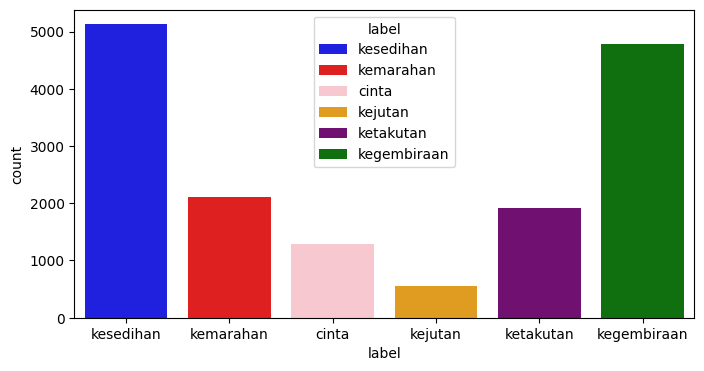

In [ ]:
# Visualisasi Jumlah Label dan Distribusi Label
plt.figure(figsize=(8,4))
palette = ['blue', 'red', 'pink', 'orange', 'purple', 'green']
sns.countplot(x='label', data=df_train, palette=palette, hue='label', legend=True);

Terlihat jika dataset tidak seimbang. Pada tahap cleaning nanti, kita akan menghapus class yang jumlahnya terlalu dan tidak seimbang yaitu dengan menghapus class love dan surprise.

4 class sisanya yaitu sadness, anger, fear, dan joy sudah dianggap mewakili emosi manusia secara keseluruhan. Kemudian dataset diseimbangkan menggunakan teknik undersampling

In [ ]:
# Cek Jumlah Null Values Data
df_train.isnull().sum()

,0
teks,0
label,207


Data memiliki 207 nilai yang kosong pada label. Kita akan menghapus label yang kosong pada tahap cleaning nanti

In [ ]:
# Cek Jumlah Duplikasi Data
df_train.duplicated().sum()

52

Terdapat 52 duplikasi data tetapi kita akan memastikan lagi duplikasi lain yaitu teks sama tetapi memiliki label emosi yang berbeda

In [ ]:
# Mengetahui Duplikasi Teks dengan Label yang Berbeda
df_train[df_train['teks'].duplicated() == True]

,teks,label
2865,saya merasa sangat rendah,kesedihan
2884,saya merasa sangat murung,kesedihan
3175,saya merasa tidak enak,kesedihan
3809,saya merasa sangat marah,kemarahan
4078,saya merasa aneh,kejutan
...,...,...
15673,saya masih merasa sedikit terguncang,ketakutan
15705,saya mulai merasa diterima oleh gaia dengan ca...,kegembiraan
15818,saya merasa senang,kegembiraan
15821,saya merasa puas dengan itu semua,kegembiraan


In [ ]:
# Mengetahui jumlah baris terduplikasi
num_duplicates = df_train['teks'].duplicated().sum()
print(f'Jumlah baris terduplikasi: {num_duplicates}')

Jumlah baris terduplikasi: 78


In [ ]:
# Print salah satu baris untuk diperiksa
df_train[df_train['teks'] == df_train.iloc[2865]['teks']]

,teks,label
2540,saya merasa sangat rendah,kesedihan
2865,saya merasa sangat rendah,kesedihan


Terlihat bahwa baris ke-2540 memiliki teks yang sama dengan teks baris ke-2865.

Kita akan membersihkan semua teks yang terduplikasi di tahap cleaning

### Val Dataset

In [ ]:
# Mengetahui Info Dataset Test
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    2000 non-null   object
 1   label   1971 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [ ]:
# Mengetahui Jumlah Label dan Distribusi Label pada setiap class
print(df_val['label'].value_counts())

label
kegembiraan                594
kesedihan                  359
 kesedihan                 211
ketakutan                  208
kemarahan                  195
cinta                      156
kejutan                     63
 kemarahan                  62
 sukacita                   62
kegembiraanjo               28
kemarahanan                  6
ketakutanfe                  6
 kesedihanad                 3
sukacita                     3
 kemarahanan                 2
 terkejut                    2
 mengherankan                1
 sayang                      1
cinta kesayangannya          1
 amarahmu                    1
kegembiraan them             1
kegembiraan world            1
kegembiraan yang glamor      1
 senang                      1
 ​​kesedihan                 1
 sukacitajo                  1
ketakutan intricate          1
Name: count, dtype: int64


Terdapat label yang tidak teratur kita akan langsung saja memperbaikinya

In [ ]:
# Dictionary untuk mapping label
val_label_mapping = {
    'kegembiraan': 'kegembiraan',
    'kesedihan': 'kesedihan',
    ' kesedihan': 'kesedihan',
    'ketakutan': 'ketakutan',
    'kemarahan': 'kemarahan',
    'cinta': 'cinta',
    'kejutan': 'kejutan',
    ' kemarahan': 'kemarahan',
    ' sukacita': 'kegembiraan',  # Mapping 'sukacita' ke 'kegembiraan'
    'kegembiraanjo': 'kegembiraan',
    'kemarahanan': 'kemarahan',
    'ketakutanfe': 'ketakutan',
    ' kesedihanad': 'kesedihan',
    'sukacita': 'kegembiraan', # Mapping 'sukacita' ke 'kegembiraan'
    ' kemarahanan': 'kemarahan',
    ' terkejut': 'kejutan', # Mapping 'terkejut' ke 'kejutan'
    ' mengherankan': 'kejutan',  # Mapping 'mengherankan' ke 'kejutan'
    ' sayang': 'cinta',  # Mapping 'sayang' ke 'cinta'
    'cinta kesayangannya': 'cinta',
    ' amarahmu': 'kemarahan',  # Mapping 'amarahmu' ke 'kemarahan'
    'kegembiraan them': 'kegembiraan',
    'kegembiraan world': 'kegembiraan',
    'kegembiraan yang glamor': 'kegembiraan',
    ' senang': 'kegembiraan',  # Mapping 'senang' ke 'kegembiraan'
    ' ​​kesedihan': 'kesedihan',
    ' sukacitajo': 'kegembiraan',  # Mapping 'sukacitajo' ke 'kegembiraan'
    'ketakutan intricate': 'ketakutan'
}

# Terapkan mapping ke kolom 'label' di dataframe
df_val['label'] = df_val['label'].map(val_label_mapping)

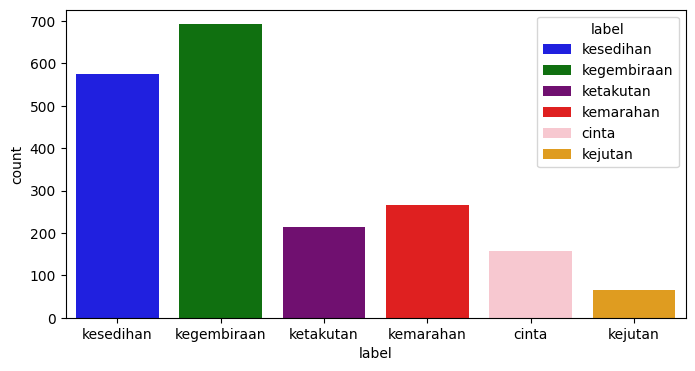

In [ ]:
# Visualisasi Jumlah Label dan Distribusi Label
plt.figure(figsize=(8,4))
palette = ['blue', 'green', 'purple', 'red', 'pink', 'orange']
sns.countplot(x='label', data=df_val, palette=palette, hue='label', legend=True);

Terlihat jika dataset tidak seimbang. Pada tahap cleaning nanti, kita akan menghapus class yang jumlahnya terlalu dan tidak seimbang yaitu dengan menghapus class love dan surprise.

4 class sisanya yaitu sadness, anger, fear, dan joy sudah dianggap mewakili emosi manusia secara keseluruhan. Kemudian dataset diseimbangkan menggunakan teknik undersampling

In [ ]:
# Cek Jumlah Null Values Data
df_val.isnull().sum()

,0
teks,0
label,29


Data memiliki 22 nilai yang kosong pada label

In [ ]:
# Cek Jumlah Duplikasi Data
df_val.duplicated().sum()

2

Data memiliki 1 duplikasi tetapi kita akan memastikan lagi duplikasi lain yaitu teks sama tetapi memiliki label emosi yang berbeda

In [ ]:
# Mengetahui Duplikasi Teks dengan Label yang Berbeda
df_val[df_val['teks'].duplicated() == True]

,teks,label
961,saya merasa tertekan lagi,kesedihan
1598,saya merasa sedikit kesal hari ini,kemarahan


terdapat teks yang terduplikasi yaitu teks baris ke-961 sama dengan baris ke-1598

## Cleaning Data

### Train Dataset

Menghapus nilai yang kosong

In [ ]:
df_train = df_train.dropna(subset=['label'])

#Cek Kembali
df_train.isnull().sum()

,0
teks,0
label,0


Menghapus nilai yang terduplikasi

In [ ]:
# Menghapus Nilai yang Terduplikasi
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
# Cek Kembali
df_train.duplicated().sum()

0

Nilai yang terduplikasi sudah hilang

Selanjutnya menghapus duplikasi teks

In [ ]:
# Menghapus Duplikasi Teks
index = df_train[df_train['teks'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
# Cek kembali
df_train[df_train['teks'].duplicated() == True]

,teks,label


Semua teks yang terduplikasi sudah hilang

### Val Dataset

Menghapus nilai yang kosong

In [ ]:
df_val = df_val.dropna(subset=['label'])

#Cek Kembali
df_val.isnull().sum()

,0
teks,0
label,0


Menghapus nilai yang terduplikasi

In [ ]:
# Menghapus Nilai yang Terduplikasi
index = df_val[df_val.duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [ ]:
# Cek Kembali
df_val.duplicated().sum()

0

Nilai yang terduplikasi sudah hilang

Selanjutnya menghapus duplikasi teks

In [ ]:
# Menghapus Duplikasi Teks
index = df_val[df_val['teks'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [ ]:
# Cek Kembali
df_val[df_val['teks'].duplicated() == True]

,teks,label


Semua teks yang terduplikasi sudah hilang

### Undersampling Data

Jika kita lihat pada assesing data terdapat data yang unbalanced. Berikut kita akan menyamakan datanya.

In [ ]:
# Hapus kelas yang tidak diinginkan
df_train = df_train[~df_train['label'].isin(['cinta', 'kejutan'])]
df_val = df_val[~df_val['label'].isin(['cinta', 'kejutan'])]

In [ ]:
# Fungsi untuk menyeimbangkan dataset
def balance_dataset(data, target_counts):
    balanced_data = []
    for label, count in target_counts.items():
        label_data = data[data['label'] == label]
        if len(label_data) > count:
            # Downsample
            label_data = resample(label_data,
                                  replace=False,
                                  n_samples=count,
                                  random_state=42)
        # else:
        #     # Upsample (opsional)
        #     label_data = resample(label_data,
        #                           replace=True,
        #                           n_samples=count,
        #                           random_state=42)
        balanced_data.append(label_data)
    return pd.concat(balanced_data)

In [ ]:
# Menentukan jumlah target untuk setiap dataset
train_target_counts = {'kegembiraan': 1894, 'kesedihan': 1894, 'kemarahan': 1894, 'ketakutan': 1894}
val_target_counts = {'kegembiraan': 215, 'kesedihan': 215, 'kemarahan': 215, 'ketakutan': 215}

In [ ]:
# Balance datasets
df_train = balance_dataset(df_train, train_target_counts)
df_val = balance_dataset(df_val, val_target_counts)

In [ ]:
# # Simpan dataset yang sudah dibersihkan
# train_data_balanced.to_csv('train_cleaned.txt', sep='\t', index=False, header=False)
# val_data_balanced.to_csv('val_cleaned.txt', sep='\t', index=False, header=False)
# test_data_balanced.to_csv('test_cleaned.txt', sep='\t', index=False, header=False)

In [ ]:
# Cek Kembali
df_train.value_counts('label')

,count
label,
kegembiraan,1894
kemarahan,1894
kesedihan,1894
ketakutan,1894


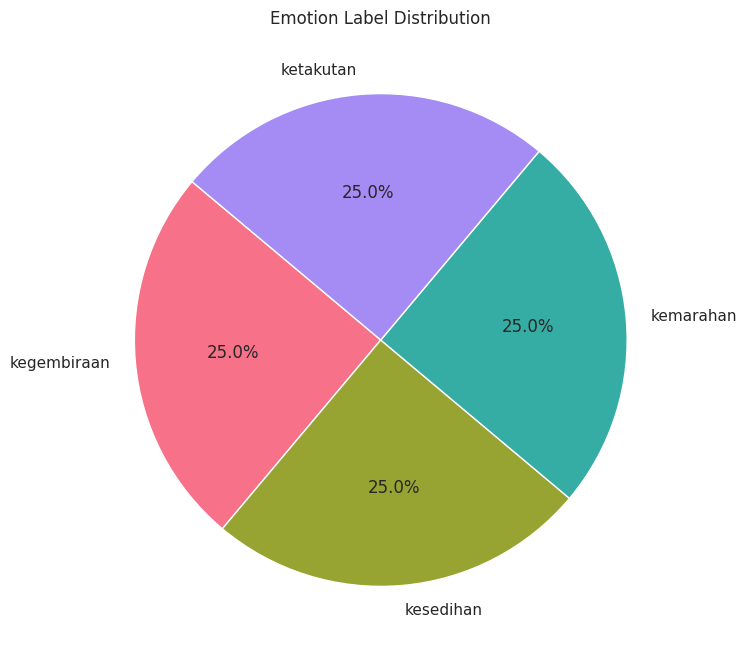

In [ ]:
# Visualisasi
label_counts = df_train['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Label Distribution')
plt.show()

In [ ]:
# Cek Kembali
df_val.value_counts('label')

,count
label,
kegembiraan,215
kemarahan,215
kesedihan,215
ketakutan,215


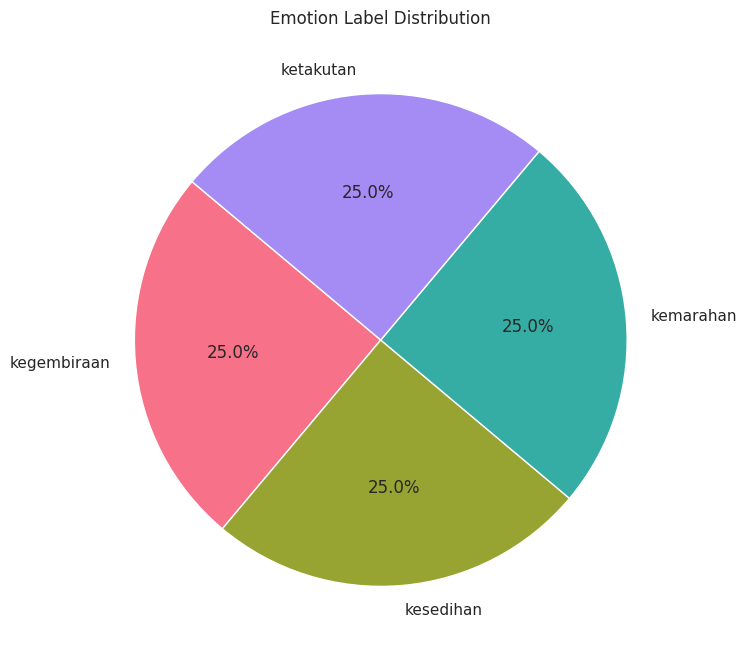

In [ ]:
# Visualisasi
label_counts = df_val['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Label Distribution')
plt.show()

## Encode Label

In [ ]:
# Encode labels
le = LabelEncoder()
df_train['label'] = le.fit_transform(df_train['label'])
df_val['label'] = le.transform(df_val['label'])

In [ ]:
# Menampilkan pemetaan label dan nilai numerik
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")

kegembiraan: 0
kemarahan: 1
kesedihan: 2
ketakutan: 3


In [ ]:
import pickle
from google.colab import drive

# Memasang Google Drive
drive.mount('/content/drive')

# Menyimpan file pickle ke Google Drive
with open('/content/drive/My Drive/Model-IndoBERT/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Tokenizer

In [ ]:
# Define tokenizer and preprocess data function
tokenizer = AlbertTokenizer.from_pretrained('indobenchmark/indobert-lite-large-p2')
max_length = 128

def preprocess_data(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_masks)

# Preprocess data training
train_input_ids, train_attention_masks = preprocess_data(df_train['teks'].values, tokenizer, max_length)
train_labels = tf.convert_to_tensor(df_train['label'].values)

# Preprocess data validation
val_input_ids, val_attention_masks = preprocess_data(df_val['teks'].values, tokenizer, max_length)
val_labels = tf.convert_to_tensor(df_val['label'].values)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


## Create TensorFlow Dataset

In [ ]:
# Convert preprocessed data to numpy arrays
train_input_ids = np.array(train_input_ids)
val_input_ids = np.array(val_input_ids)
train_attention_masks = np.array(train_attention_masks)
val_attention_masks = np.array(val_attention_masks)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

print(type(train_input_ids))  # Should print: <class 'numpy.ndarray'>
print(type(train_attention_masks))  # Should print: <class 'numpy.ndarray'>
print(type(train_labels))  # Should print: <class 'numpy.ndarray'>
print(type(val_input_ids))  # Should print: <class 'numpy.ndarray'>
print(type(val_attention_masks))  # Should print: <class 'numpy.ndarray'>
print(type(val_labels))  # Should print: <class 'numpy.ndarray'>

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# Convert preprocessed data to tensors (Assuming you have preprocessed df_val separately)
train_input_ids = tf.convert_to_tensor(train_input_ids, dtype=tf.int32)
val_input_ids = tf.convert_to_tensor(val_input_ids, dtype=tf.int32)
train_attention_masks = tf.convert_to_tensor(train_attention_masks, dtype=tf.int32)
val_attention_masks = tf.convert_to_tensor(val_attention_masks, dtype=tf.int32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.int32)


# Membuat dataset
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_input_ids, "attention_masks": train_attention_masks}, train_labels
)).shuffle(len(train_input_ids)).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_input_ids, "attention_masks": val_attention_masks}, val_labels
)).batch(batch_size)

## Membangun Model

In [ ]:
def create_model():
    bert_model = TFAutoModel.from_pretrained('indobenchmark/indobert-lite-large-p2')

    # # Freeze lapisan IndoBERT kecuali beberapa lapisan terakhir
    # for layer in bert_model.layers[:-12]:  # Freeze semua kecuali 12 lapisan terakhir
    #     layer.trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')

    # Dapatkan output dari model BERT
    sequence_output = bert_model(input_ids, attention_mask=attention_masks).last_hidden_state
    pooled_output = bert_model(input_ids, attention_mask=attention_masks).pooler_output

    # Gabungkan sequence output dan pooled output
    merged_output = tf.keras.layers.concatenate([sequence_output[:, 0, :], pooled_output])


    # Menambahkan lapisan tambahan untuk klasifikasi
    dense = tf.keras.layers.Dense(128, activation='relu')(merged_output)  # Gunakan merged_output
    dropout = tf.keras.layers.Dropout(0.3)(dense)
    output = tf.keras.layers.Dense(4, activation='softmax')(dropout)

    model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()

model.summary()

tf_model.h5:   0%|          | 0.00/87.2M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-lite-large-p2 were not used when initializing TFAlbertModel: ['predictions', 'sop_classifier']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at indobenchmark/indobert-lite-large-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_albert_model (TFAlbertM  TFBaseModelOutputWithPooli   1768396   ['input_ids[0][0]',           
 odel)                       ng(last_hidden_state=(None   8          'attention_masks[0][0]',     
                             , 128, 1024),                           'input_ids[0][0]',       

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3
474/474 [==============================] - 1193s 2s/step - loss: 0.9541 - accuracy: 0.5865 - val_loss: 0.4270 - val_accuracy: 0.8535
Epoch 2/3
474/474 [==============================] - 1135s 2s/step - loss: 0.4562 - accuracy: 0.8485 - val_loss: 0.4113 - val_accuracy: 0.8547
Epoch 3/3
474/474 [==============================] - 1172s 2s/step - loss: 0.3399 - accuracy: 0.8842 - val_loss: 0.3388 - val_accuracy: 0.8895


In [ ]:
# Evaluate the model on the validation set
eval_results = model.evaluate(val_dataset)
print(f"Validation Loss: {eval_results[0]}, Validation Accuracy: {eval_results[1]}")

54/54 [==============================] - 46s 844ms/step - loss: 0.3388 - accuracy: 0.8895
Validation Loss: 0.3387671411037445, Validation Accuracy: 0.8895348906517029


In [ ]:
# Predict on new data
def predict(texts):
    input_ids, attention_masks = preprocess_data(texts, tokenizer, max_length)
    predictions = model.predict([input_ids, attention_masks])
    return le.inverse_transform(tf.argmax(predictions, axis=1))

# Contoh prediksi
teks = ["Aku tidak bisa tidur malam ini, pikiranku dipenuhi rasa takut yang tak bisa kuhindari."
         ]
predictions = predict(teks)
print(predictions)

1/1 [==============================] - 0s 206ms/step
['ketakutan']


54/54 [==============================] - 56s 845ms/step


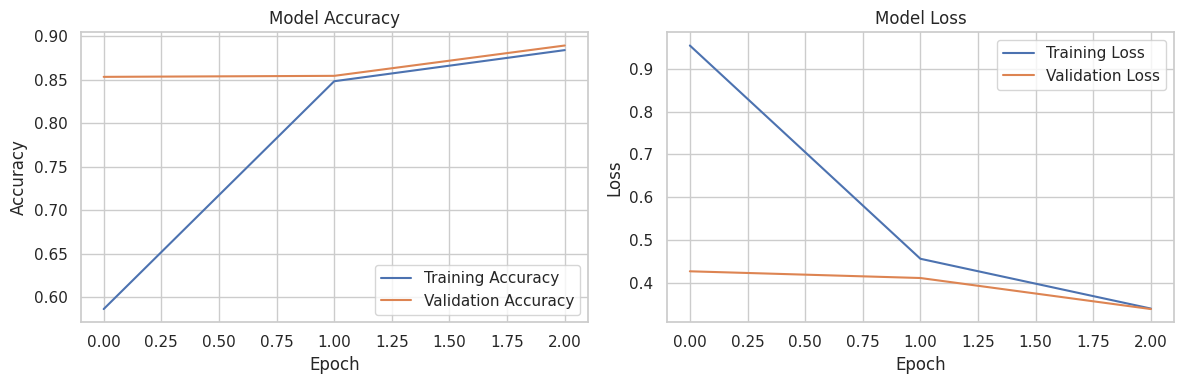

In [ ]:
# Prediksi pada data validasi
y_pred = model.predict(val_dataset)
y_pred = tf.argmax(y_pred, axis=1)
y_true = val_labels  # Asumsikan val_labels adalah label sebenarnya dari data validasi

# Grafik Akurasi dan Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

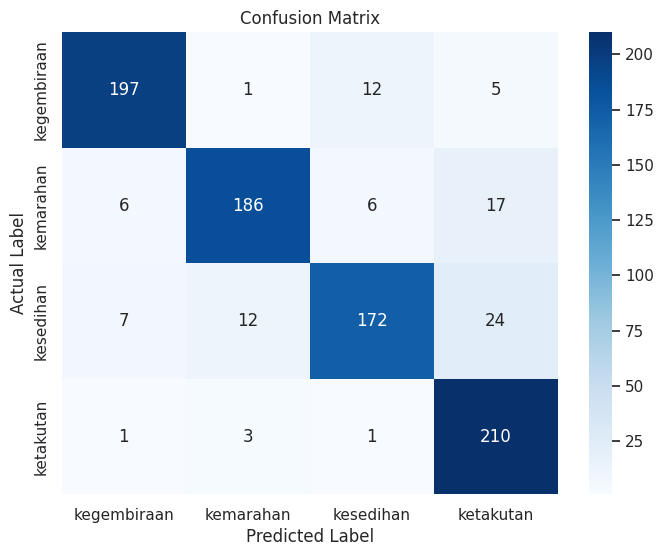

              precision    recall  f1-score   support

 kegembiraan       0.93      0.92      0.92       215
   kemarahan       0.92      0.87      0.89       215
   kesedihan       0.90      0.80      0.85       215
   ketakutan       0.82      0.98      0.89       215

    accuracy                           0.89       860
   macro avg       0.89      0.89      0.89       860
weighted avg       0.89      0.89      0.89       860



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=le.classes_))

In [ ]:
# Menyimpan model ke Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Menyimpan model dalam format SavedModel
model.save('/content/drive/My Drive/Model-IndoBERT/nlp_emotion_indobert_saved_model')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
